# Datathon #6 - Classification

This week, you will train a set of classifiers to label LEGO sets by theme, based on other metadata about the sets (year, number of parts, colors, or some combination of them). 

You should test at least 5 different classifiers:
+ kNN
+ Naïve Bayes
+ Decision Tree
+ Random Forest
+ Neural Network


For each classifier, report:
1. What parameters (if any) you tuned.
2. How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
3. Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).

In [116]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

We will use a variant of the second dataset from last week, adding a "theme" column.

** LEGO Colors by Set + Theme** — Contains data on the colors of the pieces in each LEGO set.

- Set Num = A unique alphanumeric ID number for each set. 
- Set Name = The official name of the set (some names are reused for more than one set).
- Year = The year the set was released.
- Num Parts = Total number of parts listed on the box.
- Theme = The theme the set was released under ("Technic", "Ninjago", "Star Wars", "City", etc.)
- [Colors] = Number of parts of each color in the set, according to the Rebrickable database.

You can also get more data about individual sets by going to http://rebrickable.com/sets/{SetNum}

In [117]:
# Import data, remove NaN
lego_frame_full = pd.read_excel('Set Color Data+Themes.xlsx')
lego_frame_full.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 most popular themes.
lego_frame = lego_frame_full[(lego_frame_full["Theme"] == "Technic") | 
                        (lego_frame_full["Theme"] == "Friends") |
                        (lego_frame_full["Theme"] == "City") |
                        (lego_frame_full["Theme"] == "Basic Set") |
                        (lego_frame_full["Theme"] == "Creator") |
                        (lego_frame_full["Theme"] == "Duplo") |
                        (lego_frame_full["Theme"] == "Star Wars") |
                        (lego_frame_full["Theme"] == "Ninjago") |
                        (lego_frame_full["Theme"] == "Construction") |
                        (lego_frame_full["Theme"] == "Airport")]

In [74]:
lego_frame.head(3)

,Set Num,Set Name,Theme,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
4,2823692,Simple and Motorized Machines Activity Pack,Technic,1997,24,24.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2818944,Structures Set,Technic,1997,439,20.0,0.0,116.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2814926,Technology Activity Set,Technic,1994,318,17.0,0.0,92.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


Some potentially useful refactorings of the data.

In [118]:
# Creates a copy of the dataframe where color counts are normalized 
#  so each gives the % of parts in the set with that color, rather than the total count.
norm_lego = lego_frame.copy()
norm_lego = norm_lego.drop([ 'Set Name', 'Set Num', 'Theme', 'Year', 'Num Parts'], axis=1)
norm_lego = norm_lego.div(norm_lego.sum(axis=1), axis=0)

# A list of all the color name columns
color_cols = norm_lego.columns
# A list of all the other numeric columns
other_cols = ["Year", "Num Parts"]

# Add back the non-numeric columns to the normalized table
norm_lego["Year"] = lego_frame["Year"]
norm_lego["Set Name"] = lego_frame["Set Name"]
norm_lego["Set Num"] = lego_frame["Set Num"]
norm_lego["Theme"] = lego_frame["Theme"]
norm_lego["Num Parts"] = lego_frame["Num Parts"]
norm_lego.head(3)

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,Very Light Orange,Violet,White,Yellow,Yellowish Green,Year,Set Name,Set Num,Theme,Num Parts
4,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Simple and Motorized Machines Activity Pack,2823692,Technic,24
8,0.045558,0.0,0.264237,0.127563,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Structures Set,2818944,Technic,439
10,0.051360,0.0,0.277946,0.006042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006042,0.003021,0.0,1994,Technology Activity Set,2814926,Technic,318


In [76]:
color_cols # The complete list of color columns

Index(['[No Color]', 'Aqua', 'Black', 'Blue', 'Blue-Violet', 'Bright Green',
       'Bright Light Blue', 'Bright Light Orange', 'Bright Light Yellow',
       'Bright Pink',
       ...
       'Trans-Very Lt Blue', 'Trans-Yellow', 'Unknown',
       'Very Light Bluish Gray', 'Very Light Gray', 'Very Light Orange',
       'Violet', 'White', 'Yellow', 'Yellowish Green'],
      dtype='object', length=131)

## Training and Test Splits
Make sure you don't accidentally test on your training data.

In [77]:
# Generate test and training sets
from sklearn.model_selection import train_test_split

color_train, color_test, theme_train, theme_test = sk.model_selection.train_test_split(
    norm_lego.drop(columns=['Year','Set Name','Set Num','Theme','Num Parts']), norm_lego['Theme'], test_size=0.4, random_state=0)


## k-Nearest Neighbors

In [78]:
from sklearn.neighbors import KNeighborsClassifier

# Be sure to look at the available parameters on each classifier.
# For example, you might want to experiment with the number of neighbours here. 
n=4   
lego_knn = KNeighborsClassifier(n_neighbors=n)
lego_knn.fit(color_train, theme_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [79]:
lego_knn_predictions = lego_knn.predict(color_test)

In [80]:
#Accuracy
skm.accuracy_score(y_true=theme_test,
                   y_pred=lego_knn_predictions)

0.6307531380753139

In [81]:
# Precision
skm.precision_score(y_true=theme_test,
                    y_pred=lego_knn_predictions,
                    average='weighted')

0.6339255141510571

In [82]:
# Recall
skm.recall_score(y_true=theme_test,
                    y_pred=lego_knn_predictions,
                    average='weighted')

0.6307531380753139

In [83]:
# F1
skm.f1_score(y_true=theme_test,
                    y_pred=lego_knn_predictions,
                    average='weighted')

0.6177822586353656

In [84]:
# Compute the confusion matrix
lego_knn_cfmat = skm.confusion_matrix(
    y_true=theme_test,
    y_pred=lego_knn_predictions,)
lego_knn_cfmat

array([[ 48,   2,   1,   7,   4,   0,   0,   0,   1,   9],
       [  3,  95,   0,   1,   0,   1,   3,   0,   0,   0],
       [ 21,  10,  28,  14,  10,   4,   3,   2,   7,   6],
       [ 10,   0,   1,  51,   0,   0,   1,   0,   1,   7],
       [ 20,  13,   7,   9,  28,   1,   4,   5,   5,  12],
       [  4,  15,   1,   1,   1,  59,   5,   1,   0,   2],
       [  3,   4,   3,   0,   8,   6,  70,   3,   1,   0],
       [  2,   2,   5,   1,   4,   1,   1,  64,   4,   2],
       [  7,   3,   5,   2,   8,   1,   1,   2,  28,  10],
       [  9,   0,   4,   8,   0,   3,   0,   0,   5, 132]])

Text(0.5,1,'Confusion Matrix')

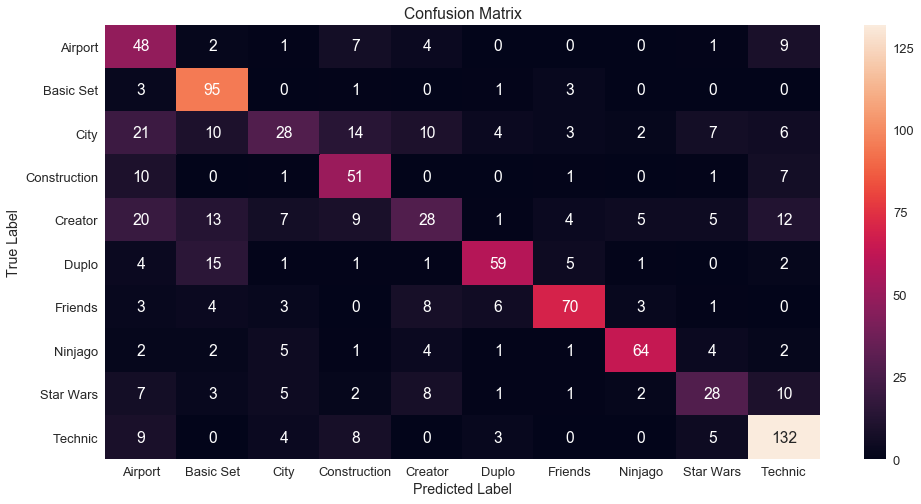

In [85]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(16,8))         # Sample figsize in inches

sns.heatmap(lego_knn_cfmat, 
            xticklabels=lego_knn.classes_,
            yticklabels=lego_knn.classes_,
            annot=True,
            ax=ax,
            fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

## Naive Bayes

In [86]:
from sklearn.naive_bayes import GaussianNB

In [87]:
lego_gnb = GaussianNB().fit(color_train, theme_train)
lego_gnb_predictions = lego_gnb.predict(color_test)
skm.accuracy_score(y_true=theme_test,
                   y_pred=lego_gnb_predictions)

0.4895397489539749

In [88]:
skm.precision_score(y_true=theme_test,
                    y_pred=lego_gnb_predictions,
                    average='weighted')

0.517947006995354

In [89]:
skm.recall_score(y_true=theme_test,
                 y_pred=lego_gnb_predictions,
                 average='weighted')

0.4895397489539749

In [90]:
skm.f1_score(y_true=theme_test,
             y_pred=lego_gnb_predictions,
             average='weighted')

0.45401952104163523

Text(0.5,1,'Confusion Matrix')

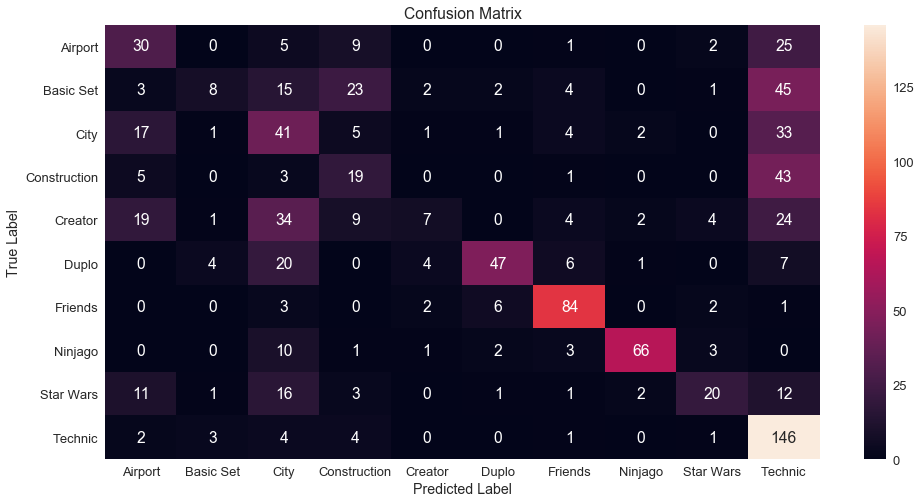

In [91]:
lego_gnb_cfmat = skm.confusion_matrix(
    y_true=theme_test,
    y_pred=lego_gnb_predictions)

fig, ax = plt.subplots(figsize=(16,8))         # Sample figsize in inches

sns.heatmap(lego_gnb_cfmat, 
            xticklabels=lego_gnb.classes_,
            yticklabels=lego_gnb.classes_,
            annot=True,
            ax=ax,
            fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

## Decision Trees

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [93]:
lego_dt = DecisionTreeClassifier().fit(color_train, theme_train)
lego_dt_predictions = lego_dt.predict(color_test)

skm.accuracy_score(y_true=theme_test,
                   y_pred=lego_dt_predictions)

0.5878661087866108

In [94]:
skm.precision_score(y_true=theme_test,
                    y_pred=lego_dt_predictions,
                    average='weighted')

0.5907904608114045

In [95]:
skm.recall_score(y_true=theme_test,
                 y_pred=lego_dt_predictions,
                 average='weighted')

0.5878661087866108

In [96]:
skm.f1_score(y_true=theme_test,
             y_pred=lego_dt_predictions,
             average='weighted')

0.5859754885385665

Text(0.5,1,'Confusion Matrix')

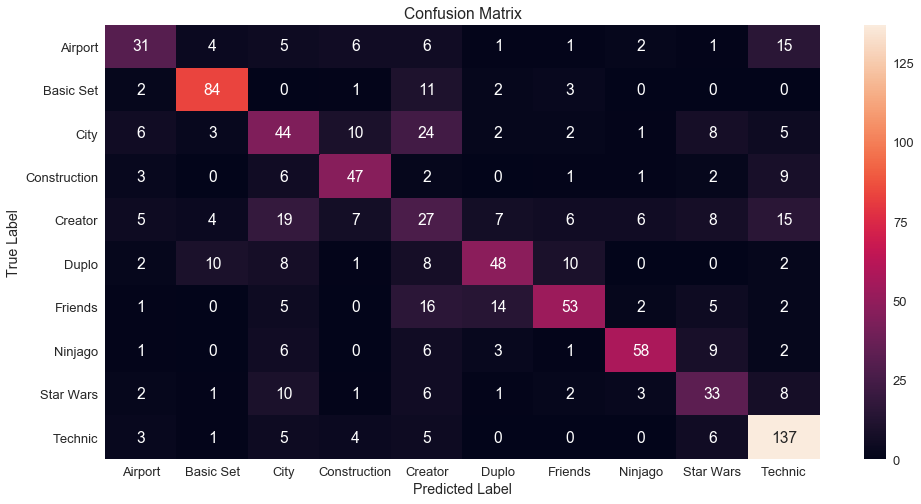

In [97]:
lego_dt_cfmat = skm.confusion_matrix(
    y_true=theme_test,
    y_pred=lego_dt_predictions)

fig, ax = plt.subplots(figsize=(16,8))         # Sample figsize in inches

sns.heatmap(lego_dt_cfmat, 
            xticklabels=lego_dt.classes_,
            yticklabels=lego_dt.classes_,
            annot=True,
            ax=ax,
            fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

#### Drawing a Decision Tree
Rendering decision trees requires the graphviz package. You can install it from the terminal or command line using:
> conda install python-graphviz

In [98]:
my_features = norm_lego.drop(columns=['Year','Set Name','Set Num','Theme','Num Parts']).columns

In [99]:
import graphviz

In [100]:
graph_data = sk.tree.export_graphviz(lego_dt, out_file=None,
                         feature_names=my_features,  
                         class_names=lego_dt.classes_,  
                         filled=True, rounded=True,  
                         special_characters=True) 

In [101]:
graph = graphviz.Source(graph_data) 
#graph

# Or save out to a file using this command:
graph.render("decision_tree") 

'decision_tree.pdf'

# Random Forest

### First, I did some preprocessing on the Set Names column...

In [119]:
import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

def remove_stop_punct(token_list):
    return [t.lower() for t in token_list if (t not in string.punctuation and t.lower() not in stopwords)]

In [120]:
norm_lego['set_name_tokens'] = [nltk.wordpunct_tokenize(set_name) for set_name in norm_lego['Set Name']]
norm_lego['Set Name'] = norm_lego['set_name_tokens'].map(remove_stop_punct)

In [121]:
norm_lego['name_length'] = [len(x) for x in norm_lego['Set Name']]
norm_lego.sort_values(by='name_length', ascending=False)

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,White,Yellow,Yellowish Green,Year,Set Name,Set Num,Theme,Num Parts,set_name_tokens,name_length
8501,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.111111,...,0.333333,0.111111,0.0,2013,"[advent, calendar, 2013, friends, day, 17, cel...",41016-18,Friends,8,"[Advent, Calendar, 2013, ,, Friends, (, Day, 1...",12
10410,0.000000,0.0,0.120879,0.032967,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.000000,0.000000,0.0,2012,"[darth, maul, ’, sith, infiltrator, mini, san,...",comcon019-1,Star Wars,91,"[Darth, Maul, ’, s, Sith, Infiltrator, -, Mini...",12
7308,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.000000,0.000000,0.0,2012,"[advent, calendar, 2012, star, wars, day, 13, ...",9509-14,Star Wars,14,"[Advent, Calendar, 2012, ,, Star, Wars, (, Day...",12
9577,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.000000,0.000000,0.0,2013,"[advent, calendar, 2013, star, wars, day, 3, f...",75023-4,Star Wars,9,"[Advent, Calendar, 2013, ,, Star, Wars, (, Day...",11
7309,0.000000,0.0,0.200000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.000000,0.000000,0.0,2012,"[advent, calendar, 2012, star, wars, day, 14, ...",9509-15,Star Wars,10,"[Advent, Calendar, 2012, ,, Star, Wars, (, Day...",11
9628,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.600000,0.000000,0.0,2014,"[advent, calendar, 2014, star, wars, day, 4, c...",75056-5,Star Wars,5,"[Advent, Calendar, 2014, Star, Wars, (, Day, 4...",11
9629,0.000000,0.0,0.181818,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.090909,0.000000,0.0,2014,"[advent, calendar, 2014, star, wars, day, 5, c...",75056-6,Star Wars,11,"[Advent, Calendar, 2014, Star, Wars, (, Day, 5...",11
9579,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.000000,0.000000,0.0,2013,"[advent, calendar, 2013, star, wars, day, 5, t...",75023-6,Star Wars,16,"[Advent, Calendar, 2013, ,, Star, Wars, (, Day...",11
6224,0.000000,0.0,0.411765,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.000000,0.176471,0.0,2006,"[advent, calendar, 2006, city, day, 3, traffic...",2193008,City,12,"[Advent, Calendar, 2006, City, (, Day, 3, ), T...",11
6238,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,...,0.700000,0.000000,0.0,2006,"[advent, calendar, 2006, city, day, 17, police...",7904-18,City,9,"[Advent, Calendar, 2006, City, (, Day, 17, ), ...",11


In [123]:
# Create dataframe with a row for each word in each set name:
words = pd.DataFrame(norm_lego['Set Name'].values.tolist())
words.fillna('a', inplace=True)
words.columns = ['word_0','word_1','word_2','word_3','word_4','word_5','word_6','word_7','word_8','word_9','word_10','word_11']
words.sample(5)

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11
141,amusement,park,hot,dog,van,a,a,a,a,a,a,a
395,tipper,trucks,loader,a,a,a,a,a,a,a,a,a
691,fun,bricks,small,red,bucket,a,a,a,a,a,a,a
797,advent,calendar,2004,creator,day,4,robot,a,a,a,a,a
1127,advent,calendar,2011,city,day,8,bed,a,a,a,a,a


In [125]:
# Encode each of the word values to a unique integer:
from sklearn import preprocessing

def encode_labels(df, col):
    le = preprocessing.LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

for col in words:
    encode_labels(words, col)
    
words.head(4)

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11
0,593,405,271,26,71,33,27,6,4,1,1,0
1,642,536,45,24,17,33,27,6,4,1,1,0
2,659,25,342,24,17,33,27,6,4,1,1,0
3,657,298,390,117,18,75,27,6,4,1,1,0


In [131]:
print( words.shape )
print( norm_lego.shape )

(2390, 12)
(2390, 138)


In [144]:
words.index = norm_lego.index

In [145]:
# Concatenate the encoded word values on the normalized lego data, with certain columns removed:
lego_data = pd.concat([words, norm_lego.drop(columns=['Set Name', 'set_name_tokens', 'name_length', 'Set Num', 'Theme'])],
                      axis=1)

In [147]:
print( lego_data.shape )

(2390, 145)


In [148]:
from sklearn.model_selection import train_test_split

color_train, color_test, theme_train, theme_test = sk.model_selection.train_test_split(
    lego_data, norm_lego['Theme'], test_size=0.4, random_state=0)


In [149]:
from sklearn.ensemble import RandomForestClassifier

### Preliminary testing indicated that there was a local minima between 1500 and 2000, so I figured I'd locate it via brute force:

In [462]:
# max_f1 = (f1, n_estimators)
max_f1 = (0,0)
for i in range(1500,2000):
    rfc = RandomForestClassifier(n_estimators=i, min_samples_split=2, min_samples_leaf=1,
                                 max_features='log2', max_depth=None, bootstrap=False,
                                 random_state=0)
    lego_rfc = rfc.fit(color_train, theme_train)
    lego_rfc_predictions = lego_rfc.predict(color_test)
    curr = skm.f1_score(y_true=theme_test,
                    y_pred=lego_rfc_predictions,
                    average='weighted')
    if curr > max_f1[0]:
        max_f1 = (curr, i)
print(max_f1)

(0.8865023615584997, 1860)


### After finding the local minima, I figured I should perform an exploration of seed variance on f1 score:

In [463]:
max_f1 = (0,0)
for i in range(0,10):
    rfc = RandomForestClassifier(n_estimators=1860, min_samples_split=2, min_samples_leaf=1,
                             max_features='log2', max_depth=None, bootstrap=False,
                             random_state=i)
    lego_rfc = rfc.fit(color_train, theme_train)
    lego_rfc_predictions = lego_rfc.predict(color_test)
    curr = skm.f1_score(y_true=theme_test,
                    y_pred=lego_rfc_predictions,
                    average='weighted')
    if curr > max_f1[0]:
        max_f1 = (curr, i)
print(max_f1)

(0.8924349368890329, 1)


### Experimented with random seeds:

In [507]:
max_f1 = (0,0)
for i in range(0,700):
    r = np.random.randint(10000)
    rfc = RandomForestClassifier(n_estimators=1880, min_samples_split=2, min_samples_leaf=1,
                             max_features='log2', max_depth=None, bootstrap=False,
                             random_state=r)
    lego_rfc = rfc.fit(color_train, theme_train)
    lego_rfc_predictions = lego_rfc.predict(color_test)
    curr = skm.f1_score(y_true=theme_test,
                    y_pred=lego_rfc_predictions,
                    average='weighted')
    if curr > max_f1[0]:
        max_f1 = (curr, r)
print(max_f1)

(0.8939407700922986, 11)


### Final Random Forest:

In [169]:
rfc = RandomForestClassifier(n_estimators=1700, min_samples_split=2, min_samples_leaf=1,
                             max_features='log2', max_depth=None, bootstrap=False,
                             random_state=0)

lego_rfc = rfc.fit(color_train, theme_train)
lego_rfc_predictions = lego_rfc.predict(color_test)    

In [170]:
lego_rfc = rfc.fit(color_train, theme_train)
lego_rfc_predictions = lego_rfc.predict(color_test)

In [171]:
skm.f1_score(y_true=theme_test,
                    y_pred=lego_rfc_predictions,
                    average='weighted')

0.8909720286177988

In [14]:
skm.accuracy_score(y_true=theme_test,
                   y_pred=lego_rfc_predictions)

0.8943514644351465

In [15]:
skm.precision_score(y_true=theme_test,
                    y_pred=lego_rfc_predictions,
                    average='weighted')

0.899971788785977

In [16]:
skm.recall_score(y_true=theme_test,
                    y_pred=lego_rfc_predictions,
                    average='weighted')

0.8943514644351465

Text(0.5,1,'Confusion Matrix')

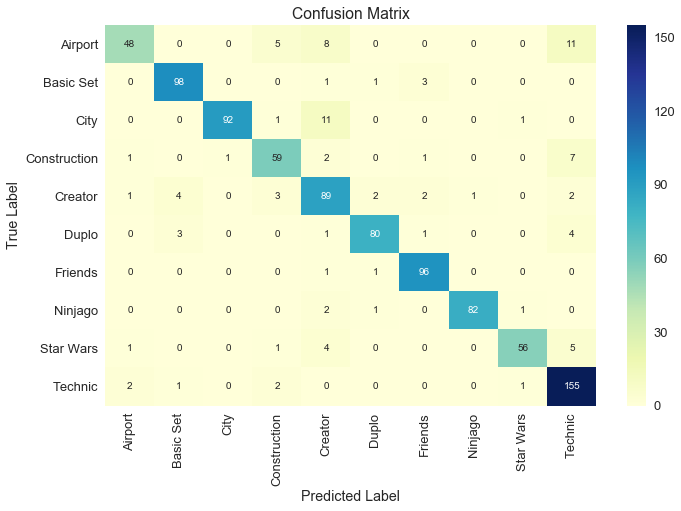

In [19]:
lego_rfc_cfmat = skm.confusion_matrix(
    y_true=theme_test,
    y_pred=lego_rfc_predictions)

plt.subplots(figsize=(11,7))         # Sample figsize in inches

sns.heatmap(lego_rfc_cfmat, 
            xticklabels=lego_rfc.classes_,
            yticklabels=lego_rfc.classes_,
            annot=True,
            cmap='YlGnBu',
            fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

## Neural Network

In [373]:
from sklearn.neural_network import MLPClassifier

In [380]:
nn = MLPClassifier(hidden_layer_sizes=(100), max_iter=1000)

In [390]:
lego_nn = nn.fit(color_train, theme_train)
lego_nn_predictions = lego_nn.predict(color_test)

In [382]:
skm.f1_score(y_true=theme_test,
                    y_pred=lego_nn_predictions,
                    average='weighted')

0.24006730730565198

In [391]:
skm.accuracy_score(y_true=theme_test,
                   y_pred=lego_nn_predictions)

0.2792887029288703

In [43]:
skm.precision_score(y_true=theme_test,
                    y_pred=lego_nn_predictions,
                    average='weighted')

0.7243257595104456

In [44]:
skm.recall_score(y_true=theme_test,
                    y_pred=lego_nn_predictions,
                    average='weighted')

0.7322175732217573

Text(0.5,1,'Confusion Matrix')

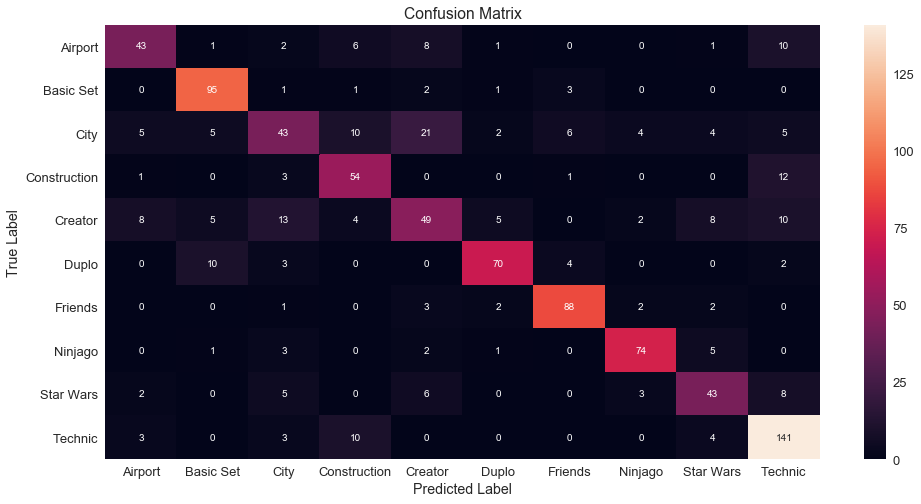

In [46]:
lego_nn_cfmat = skm.confusion_matrix(
    y_true=theme_test,
    y_pred=lego_nn_predictions)

fig, ax = plt.subplots(figsize=(16,8))         # Sample figsize in inches

sns.heatmap(lego_nn_cfmat, 
            xticklabels=lego_nn.classes_,
            yticklabels=lego_nn.classes_,
            annot=True,
            ax=ax,
            fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Voting Classifier Approach

In [249]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

#clf1 = KNeighborsClassifier(n_neighbors=4)
#clf2 = RandomForestClassifier(n_estimators=3000, criterion='gini', random_state=0, n_jobs=-1)
#clf3 = MLPClassifier(hidden_layer_sizes=(200,100,50,20,2), max_iter=1000)
#clf4 = LogisticRegression()
#eclf = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('mlp', clf3), ('lr', clf4)],
#                        voting='soft',
#                        weights=[1,10,1,1])

clf1 = KNeighborsClassifier(n_neighbors=4)
clf2 = RandomForestClassifier(n_estimators=3000, criterion='gini', random_state=0, n_jobs=-1)
clf3 = MLPClassifier(hidden_layer_sizes=(200,100,50,20,2), max_iter=1000)
clf4 = LogisticRegression()
eclf1 = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('mlp', clf3), ('lr', clf4)],
                        voting='soft',
                        weights=[1,10,1,1])

In [250]:
lego_ens1 = eclf1.fit(color_train, theme_train)
lego_ens1_pred = lego_ens1.predict(color_test)

In [251]:
skm.f1_score(y_true=theme_test,
                    y_pred=lego_ens1_pred,
                    average='weighted')

0.7657607071023562

In [252]:
clf5 = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, activation='logistic', solver='lbfgs')
clf6 = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, activation='relu', solver='lbfgs')
clf7 = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, activation='tanh', solver='lbfgs')
eclf2 = VotingClassifier(estimators=[('nn1', clf5), ('nn2', clf6), ('nn3', clf7)])

In [253]:
lego_ens2 = eclf2.fit(color_train, theme_train)
lego_ens2_pred = lego_ens2.predict(color_test)
skm.f1_score(y_true=theme_test,
                    y_pred=lego_ens2_pred,
                    average='weighted')

0.6878416614931148

### Activation Function Comparison

In [267]:
lego_clf5 = clf5.fit(color_train, theme_train)
lego_clf6 = clf6.fit(color_train, theme_train)
lego_clf7 = clf7.fit(color_train, theme_train)

In [268]:
lego_clf5_pred = lego_clf5.predict(color_test)
lego_clf6_pred = lego_clf6.predict(color_test)
lego_clf7_pred = lego_clf7.predict(color_test)

In [269]:
# sigmoid
skm.f1_score(y_true=theme_test,
                    y_pred=lego_clf5_pred,
                    average='weighted')

0.6664257370574811

In [270]:
# relu
skm.f1_score(y_true=theme_test,
                    y_pred=lego_clf6_pred,
                    average='weighted')

0.7000264422988269

In [271]:
# tanh
skm.f1_score(y_true=theme_test,
                    y_pred=lego_clf7_pred,
                    average='weighted')

0.6848503311915234

*relu consistently outperforms sigmoid (logistic) and tanh*

In [281]:
nn_relu = MLPClassifier(hidden_layer_sizes=(1000,500), max_iter=1000, activation='relu', solver='lbfgs')
lego_nn_relu = nn_relu.fit(color_train, theme_train)
lego_nn_relu_pred = lego_nn_relu.predict(color_test)
skm.f1_score(y_true=theme_test,
                    y_pred=lego_nn_relu_pred,
                    average='weighted')

0.7055482602346475